# Datawhale 零基础入门数据挖掘-Baseline

## Baseline-v1.0 版

Tip:这是一个最初始baseline版本,抛砖引玉,为大家提供一个基本Baseline和一个竞赛流程的基本介绍，欢迎大家多多交流。

**赛题：零基础入门数据挖掘 - 二手车交易价格预测**

地址：https://tianchi.aliyun.com/competition/entrance/231784/introduction?spm=5176.12281957.1004.1.38b02448ausjSX

### Step 1:导入函数工具箱

In [256]:
## 基础工具
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time
from tqdm import tqdm

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split,KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

### Step 2:数据读取

In [257]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [258]:
## 通过Pandas对于数据进行读取 (pandas是一个很友好的数据读取函数库)
Train_data = pd.read_csv('./data/used_car_train_20200313.csv', sep=' ')
TestA_data = pd.read_csv('./data/used_car_testA_20200313.csv', sep=' ')

## 输出数据的大小信息
print('Train data shape:',Train_data.shape)
print('TestA data shape:',TestA_data.shape)

Train data shape: (150000, 31)
TestA data shape: (50000, 30)


In [259]:
## 通过 .columns 查看列名
Train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

In [260]:
TestA_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
SaleID               50000 non-null int64
name                 50000 non-null int64
regDate              50000 non-null int64
model                50000 non-null float64
brand                50000 non-null int64
bodyType             48587 non-null float64
fuelType             47107 non-null float64
gearbox              48090 non-null float64
power                50000 non-null int64
kilometer            50000 non-null float64
notRepairedDamage    50000 non-null object
regionCode           50000 non-null int64
seller               50000 non-null int64
offerType            50000 non-null int64
creatDate            50000 non-null int64
v_0                  50000 non-null float64
v_1                  50000 non-null float64
v_2                  50000 non-null float64
v_3                  50000 non-null float64
v_4                  50000 non-null float64
v_5                  50000 non

### Step 3:特征与标签构建

#### 1) 提取数值类型特征列名

In [261]:
numerical_cols = Train_data.select_dtypes(exclude = 'object').columns
print(numerical_cols)

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'regionCode', 'seller', 'offerType',
       'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6',
       'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14'],
      dtype='object')


In [262]:
categorical_cols = Train_data.select_dtypes(include = 'object').columns
print(categorical_cols)

Index(['notRepairedDamage'], dtype='object')


#### 2) 构建训练和测试样本

In [263]:
## 定义了一个统计函数，方便后续信息统计
def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))
    print('_std',np.std(data))
    print('_var',np.var(data))

#### 3) 统计标签的基本分布信息

### Step 4: 特征工程

#### 1) 处理异常值

##### 处理power

In [264]:
# method 2，截断，截断处为375
# Train_data.loc[Train_data['power'] > 375,'power'] = 375

# method 3，截断，截断处为2500
# Train_data.loc[Train_data['power'] > 2500,'power'] = 2500

# method 4, 极大值单独处理，不行，不存在规律

# method 5，截断，截断处为600， 直接赛题信息给出了
Train_data.loc[Train_data['power'] > 600,'power'] = 600

# 分桶
#bin = [i*10 for i in range(31)]
#Train_data['power_bin'] = pd.cut(Train_data['power'], bin, labels=False)
#print(Train_data[['power_bin', 'power']].head())


# method 6, 取log并归一化
min_max_scaler = preprocessing.MinMaxScaler()
Train_data['power'] = np.log(Train_data['power'] + 1) 
Train_data['power'] = ((Train_data['power'] - np.min(Train_data['power'])) / (np.max(Train_data['power']) - np.min(Train_data['power'])))
#Train_data['power'].plot.hist()


##### 处理kilometer
数值型和分类型处理

In [265]:
#Train_data['kilometer'] = Train_data['kilometer'].astype('category')

#### 2) 单一数值型特征处理

In [266]:
# 处理name
# 扔进模型跑一遍，有提升就保留，没有提升就删除。
# Train_data['name'] = Train_data['name'].astype('category')

In [267]:
# 处理model
## 1.保留空值

## 2.直接删除空值
# Train_data = Train_data[Train_data['model'].notna()]

## 3.填充缺失值，直接用众数填充
#Train_data['model'].fillna(0,inplace=True)

#Train_data['model'] = Train_data['model'].astype('category')

In [268]:
# 处理brand
#Train_data['brand'] = Train_data['brand'].astype('category')

In [269]:
# 处理regionCode
## 1.不处理，直接保留。
## 2. 保留原来，并构造city特征
#Train_data['city'] = Train_data['regionCode'].apply(lambda x : str(x)[:-3])
#Train_data['city'] = Train_data['city'] * 1
## 3.删除regionCode,只保留city
#Train_data = Train_data.drop(['regionCode'], axis=1)

In [270]:
# 处理regDate和creatDate
## 分别拆分 年 月 日
## 然后createDate-regDate得到使用时间
date_cols = ['regDate', 'creatDate']

def date_proc(x):
    m = int(x[4:6])
    if m == 0:
        #m = 1
        m = x[6:]
    return x[:4] + '-' + str(m) + '-' + x[6:]


for f in tqdm(date_cols):
    Train_data[f] = pd.to_datetime(Train_data[f].astype('str').apply(date_proc))
    Train_data[f + '_year'] = Train_data[f].dt.year
    Train_data[f + '_month'] = Train_data[f].dt.month
    Train_data[f + '_day'] = Train_data[f].dt.day
    Train_data[f + '_dayofweek'] = Train_data[f].dt.dayofweek
    
    
Train_data['used_time_day'] = (pd.to_datetime(Train_data['creatDate'], format='%Y%m%d', errors='coerce') - 
                            pd.to_datetime(Train_data['regDate'], format='%Y%m%d', errors='coerce')).dt.days
Train_data['used_time_month'] = round(Train_data['used_time_day'] / 30)
Train_data['used_time_year'] = round(Train_data['used_time_day'] / 365)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.29it/s]


In [271]:
Train_data['creatDate'] = Train_data['creatDate'].dt.year * 10000 + Train_data['creatDate'].dt.month * 100 + Train_data['creatDate'].dt.day
Train_data['regDate'] = Train_data['regDate'].dt.year * 10000 + Train_data['regDate'].dt.month * 100 + Train_data['regDate'].dt.day

#### 3) 单一分类型特征处理

In [272]:
# 处理bodyType，保留空值

# 处理fuelType，
## 1.保留空值
## 2.合并2-6为一类
Train_data.loc[Train_data['fuelType'] == 3,'fuelType'] = 2 
Train_data.loc[Train_data['fuelType'] == 4,'fuelType'] = 2 
Train_data.loc[Train_data['fuelType'] == 5,'fuelType'] = 2 
Train_data.loc[Train_data['fuelType'] == 6,'fuelType'] = 2 


# 处理seller，offerType，直接删除

#处理notRepairedDamage
Train_data['notRepairedDamage'].replace('-', np.nan , inplace=True)
Train_data['notRepairedDamage'] = Train_data['notRepairedDamage'].astype('float64')

In [273]:
#Train_data.drop(Train_data[(Train_data['v_14'] >= 5)].index, inplace=True)
#Train_data.drop(Train_data[(Train_data['v_5'] < 0.2) & (Train_data['v_5'] > 0.1)].index, inplace=True)

#df.drop(df[df.score < 50].index, inplace=True)

#### 4) 特征构造-多个特征的交互


##### 基于业务知识

In [274]:
# 使用年限折旧
def depreciation_year1(year):
    if year <= 3:
        return 1 - year * 0.15
    elif year > 3 and  year <= 7:
        return 0.55 - (year-3) * 0.1
    elif year > 7 and  year <= 10:
        return 0.25 - (year-7) * 0.05
    else:
        return 0

Train_data['depreciation_year1'] = Train_data['used_time_year'].apply(lambda x: depreciation_year1(x))

def depreciation_year2(year):
    if year <= 3:
        return 1 - 0.85 * year * 0.11
    elif year > 3 and  year <= 7:
        return 0.7195 - 0.85 * (year-3) * 0.1
    elif year > 7 and  year <= 10:
        return 0.3795 - 0.85 * (year-7) * 0.09
    else:
        return 0.15
    
Train_data['depreciation_year2'] = Train_data['used_time_year'].apply(lambda x: depreciation_year2(x))

In [275]:
#行驶里程
def depreciation_kilometer(kilo):
    if kilo <= 6:
        return 1 - kilo * 5 / 90
    elif kilo > 6 and  kilo <= 12:
        return 0.66667 - (kilo-6) * 4 / 90
    elif kilo > 12 and  kilo <= 18:
        return 0.4 - (kilo-12) * 3 / 90
    elif kilo > 18 and  kilo <= 24:
        return 0.2 - (kilo-18) * 2 / 90
    elif kilo > 24 and  kilo <= 30:
        return 0.06667 - (kilo-24) * 1 / 90
Train_data['depreciation_kilo'] = Train_data['used_time_year'].apply(lambda x: depreciation_year1(x))

##### 构建统计量

In [276]:
# 构建统计量函数
def Group_Statistic(df,feature,Target):
    Train_gb = df.groupby(feature)
    all_info = {}
    for kind, kind_data in Train_gb:
        info = {}
        kind_data = kind_data[kind_data[Target] > 0]
        info[feature + '_unique'] = len(kind_data[feature].unique())
        info[feature + '_amount'] = len(kind_data)
        info[feature + '_' + Target + '_max'] = kind_data[Target].max()
        info[feature + '_' + Target + '_median'] = kind_data[Target].median()
        info[feature + '_' + Target + '_min'] = kind_data[Target].min()
        info[feature + '_' + Target + '_sum'] = kind_data[Target].sum()
        info[feature + '_' + Target + '_std'] = kind_data[Target].std()
        info[feature + '_' + Target + '_average'] = round(kind_data[Target].sum() / (len(kind_data) + 1), 2)
        all_info[kind] = info
    brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={'index': feature})
    return df.merge(brand_fe, how='left', on=feature)

In [277]:
Train_data = Group_Statistic(Train_data,'brand','price')
Train_data = Group_Statistic(Train_data,'model','price')
Train_data = Group_Statistic(Train_data,'kilometer','price')
Train_data = Group_Statistic(Train_data,'regionCode','price')
Train_data = Group_Statistic(Train_data,'used_time_year','price')
Train_data = Group_Statistic(Train_data,'used_time_month','price')
Train_data = Group_Statistic(Train_data,'used_time_day','price')
Train_data = Group_Statistic(Train_data,'power','price')
Train_data = Group_Statistic(Train_data,'fuelType','price')
Train_data = Group_Statistic(Train_data,'notRepairedDamage','price')
Train_data = Group_Statistic(Train_data,'bodyType','price')

Train_data = Group_Statistic(Train_data,'regionCode','used_time_day')
Train_data = Group_Statistic(Train_data,'regionCode','used_time_month')
Train_data = Group_Statistic(Train_data,'regionCode','used_time_year')

Train_data = Group_Statistic(Train_data,'regionCode','v_12')
Train_data = Group_Statistic(Train_data,'regionCode','v_12')
Train_data = Group_Statistic(Train_data,'regionCode','v_12')

Train_data = Group_Statistic(Train_data,'regionCode','v_3')
Train_data = Group_Statistic(Train_data,'regionCode','v_3')
Train_data = Group_Statistic(Train_data,'regionCode','v_3')

Train_data = Group_Statistic(Train_data,'regionCode','v_0')
Train_data = Group_Statistic(Train_data,'regionCode','v_0')
Train_data = Group_Statistic(Train_data,'regionCode','v_0')

Train_data = Group_Statistic(Train_data,'regionCode','v_8')
Train_data = Group_Statistic(Train_data,'regionCode','v_8')
Train_data = Group_Statistic(Train_data,'regionCode','v_8')

Train_data = Group_Statistic(Train_data,'used_time_year','v_3')
Train_data = Group_Statistic(Train_data,'used_time_year','v_3')
Train_data = Group_Statistic(Train_data,'used_time_year','v_3')

Train_data = Group_Statistic(Train_data,'power','used_time_day')
Train_data = Group_Statistic(Train_data,'power','used_time_month')
Train_data = Group_Statistic(Train_data,'power','used_time_year')

Train_data = Group_Statistic(Train_data,'brand','used_time_day')
Train_data = Group_Statistic(Train_data,'model','used_time_day')

Train_data['model'] = Train_data['model'].map(lambda x:str(x))
Train_data['brand'] =Train_data['brand'].map(lambda x:str(x))
Train_data['Model_brand'] = Train_data['model'].str.cat(Train_data['brand'], sep = '_')

Train_data = Group_Statistic(Train_data,'Model_brand','price')
Train_data = Group_Statistic(Train_data,'Model_brand','used_time_day')
Train_data = Group_Statistic(Train_data,'Model_brand','used_time_month')
Train_data = Group_Statistic(Train_data,'Model_brand','used_time_year')


Train_data = Train_data.drop(['Model_brand'], axis=1)

In [278]:
#Train_data['model'] = Train_data['model'].map(lambda x:str(x))
#Train_data['brand'] =Train_data['brand'].map(lambda x:str(x))
#Train_data['Model_brand'] = Train_data['model'].str.cat(Train_data['brand'], sep = '_')
#Train_data = Group_Statistic(Train_data,'Model_brand','price')



#### 4) 对price做log处理

In [279]:
## 选择特征列
# feature_cols = [col for col in numerical_cols if col not in ['SaleID','name','regDate','creatDate','price','model','brand','regionCode','seller']]

feature_cols = [col for col in Train_data.columns if col not in ['SaleID','seller','offerType']]
#feature_cols  = [col for col in feature_cols if 'Type' not in col]


#feature_cols.append('power_bin')
#Train_data = Train_data.reindex(columns=feature_cols)
#TestA_data = TestA_data.reindex(columns=feature_cols)
feature_cols.remove('price')

## 提取特征列，标签列构造训练样本和测试样本
X_data = Train_data[feature_cols]
Y_data = Train_data['price']

#X_test  = TestA_data[feature_cols]

print('X train shape:',X_data.shape)
#print('X test shape:',X_test.shape)

X_data.info()
Y_data = np.log(Y_data + 1)

X train shape: (150000, 593)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 0 to 149999
Columns: 593 entries, name to Model_brand_used_time_year_average
dtypes: float64(578), int64(13), object(2)
memory usage: 679.8+ MB


### Step 5:模型训练与预测

#### 1) 利用xgb进行五折交叉验证查看模型的参数效果

In [280]:
## xgb-Model

xgr = xgb.XGBRegressor(n_estimators=150, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #,objective ='reg:squarederror'

scores_train = []
scores = []

## 5折交叉验证方式
sk=KFold(n_splits=5,shuffle=True,random_state=0)
for train_ind,val_ind in sk.split(X_data,Y_data):
    
    train_x=X_data.iloc[train_ind].values
    train_y=Y_data.iloc[train_ind]
    val_x=X_data.iloc[val_ind].values
    val_y=Y_data.iloc[val_ind]
    
    xgr.fit(train_x,train_y)
    pred_train_xgb=xgr.predict(train_x)
    pred_xgb=xgr.predict(val_x)
    
    score_train = mean_absolute_error(train_y,pred_train_xgb)
    scores_train.append(score_train)
    score = mean_absolute_error(val_y,pred_xgb)
    scores.append(score)

print('Train mae:',np.mean(score_train))
print('Val mae',np.mean(scores))

[18:27:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:43:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:59:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:15:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train mae: 0.10782507722076108
Val mae 0.12679781771854454


In [281]:
train_y_Origin = np.exp(train_y) - 1
pred_train_xgb_Origin = np.exp(pred_train_xgb) - 1
Train_Score_MAE = mean_absolute_error(train_y_Origin,pred_train_xgb_Origin)
print(Train_Score_MAE)

514.9696334174156


In [282]:
val_y_Origin = np.exp(val_y) - 1
pred_xgb_Origin = np.exp(pred_xgb) - 1
val_Score_MAE = mean_absolute_error(val_y_Origin,pred_xgb_Origin)
print(val_Score_MAE)

582.5129734918594


In [283]:
# XGB自带图形
#from xgboost import plot_importance
#from matplotlib import pyplot
#plot_importance(xgr)
#pyplot.show()

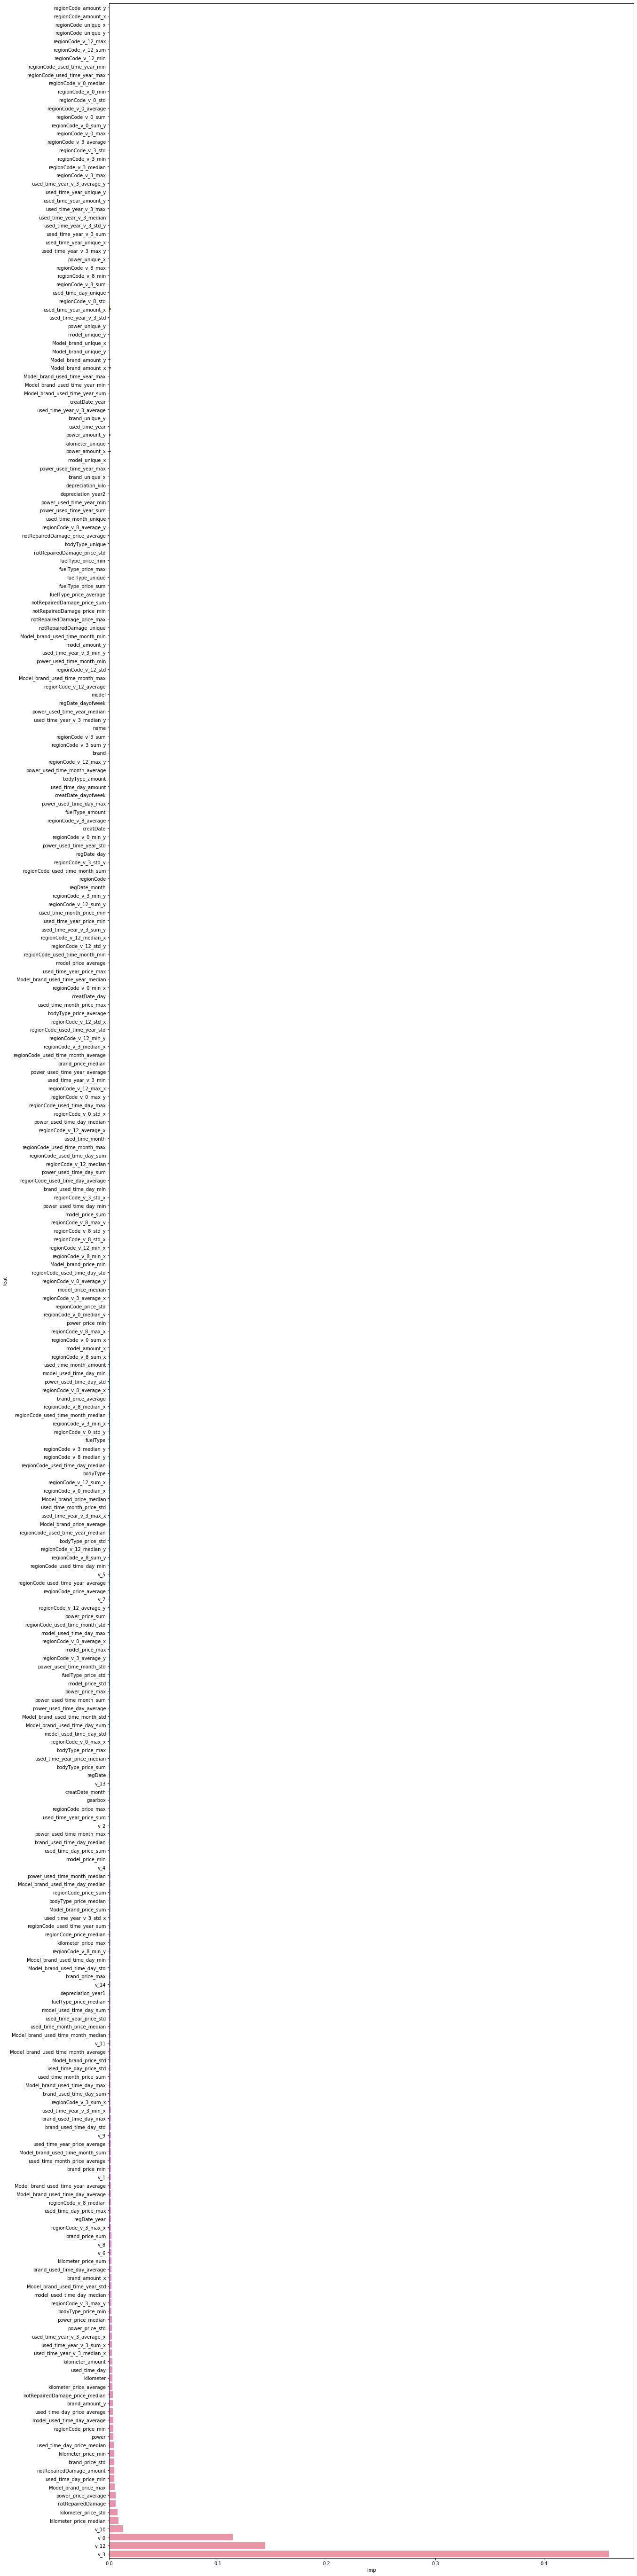

In [284]:
# 特征重要度排名
feature_cols = X_data.columns
feat_imp_df = pd.DataFrame({'feat': feature_cols, 'imp': 0})
feat_imp_df['imp'] = xgr.feature_importances_

plt.figure(figsize=(20, 100))
feat_imp_df = feat_imp_df.sort_values('imp').reset_index(drop=False)
sns.barplot(x='imp', y='feat', data=feat_imp_df)